#Multivariate LSTM model

In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import mysql.connector
import matplotlib.pyplot as plt


Constructing the dataset

In [47]:
db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="yahoonet",
    database="AIProject"
)

def make_multivariate_sequences(array, n_steps):
    """array shape: (timesteps, n_features)"""
    X, y = [], []
    for i in range(len(array)-n_steps):
        X.append(array[i:i+n_steps,:])      # n_steps x n_features
        y.append(array[i+n_steps,0])        # predict market_value next
    return np.array(X), np.array(y)

# --- Load your merged time series ---
# (Here df_t is your transfer history with date & market_value)
# (df_f is your player_features table with static columns)

df_t = pd.read_sql("SELECT transfermarkt_id, transfer_date, market_value FROM player_transfer_history ORDER BY transfermarkt_id, transfer_date", db)
df_f = pd.read_sql("SELECT * FROM player_features", db)

# Merge static features onto each time row
df = df_t.merge(df_f[["player_id","total_injuries","sentiment_mean","avg_cards_per_match"]],
                left_on="transfermarkt_id", right_on="player_id", how="left")

# Sort by time per player
df = df.sort_values(["transfermarkt_id","transfer_date"])

df.head()

n_steps = 3
X_list, y_list, player_index = [], [], []

for pid, group in df.groupby("transfermarkt_id"):
    # Select columns for features
    features = group[["market_value","total_injuries","sentiment_mean","avg_cards_per_match"]].fillna(0).values
    
    # Scale per player for all features
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(features)

    Xp, yp = make_multivariate_sequences(scaled, n_steps)
    if len(Xp)==0:
        continue
    X_list.append(Xp)
    y_list.append(yp)
    player_index.extend([pid]*len(yp))

# Stack across all players
X = np.vstack(X_list)   # shape: (samples, n_steps, n_features)
y = np.concatenate(y_list)  # shape: (samples,)


C:\Users\Himanshu Saxena\AppData\Local\Temp\ipykernel_40888\1878833527.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_t = pd.read_sql("SELECT transfermarkt_id, transfer_date, market_value FROM player_transfer_history ORDER BY transfermarkt_id, transfer_date", db)
C:\Users\Himanshu Saxena\AppData\Local\Temp\ipykernel_40888\1878833527.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_f = pd.read_sql("SELECT * FROM player_features", db)


Check for missing values

In [48]:
print(df.isnull().sum())

transfermarkt_id       0
transfer_date          0
market_value           0
player_id              0
total_injuries         0
sentiment_mean         0
avg_cards_per_match    0
dtype: int64


LSTM Building

In [49]:
n_features = X.shape[2]

model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2, shuffle=True)


Epoch 1/50


C:\Users\Himanshu Saxena\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1213 - val_loss: 0.1595
Epoch 2/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0986 - val_loss: 0.1409
Epoch 3/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0918 - val_loss: 0.1426
Epoch 4/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0903 - val_loss: 0.1427
Epoch 5/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0894 - val_loss: 0.1426
Epoch 6/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0897 - val_loss: 0.1460
Epoch 7/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0892 - val_loss: 0.1351
Epoch 8/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0884 - val_loss: 0.1485
Epoch 9/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0881 - val_loss: 0.1372
Epoch 10/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0876 - val_loss: 0.1401
Epoch 11/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0877 - val_loss: 0.1404
Epoch 12/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

Prediction

--------------------------------
Predicting for player ID: 7492
--------------------------------
[   8198    8198    8198 ... 1190411 1190411 1190411]
[False False False ... False False False]
Error during prediction: math domain error
--------------------------------


C:\Users\Himanshu Saxena\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


--------------------------------
Predicting for player ID: 28396
--------------------------------
[   8198    8198    8198 ... 1190411 1190411 1190411]
[False False False ... False False False]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
True values: [0.         0.13333333 1.         0.66666667 0.5        0.5
 0.13333333 0.13333333 0.05333333]
Predicted values: [0.13374645 0.13374645 0.41800588 0.7796943  0.72069514 0.50418544
 0.5973351  0.09356336 0.21737489]
--------------------------------
--------------------------------
    transfermarkt_id transfer_date  market_value  player_id  total_injuries  \
20             28396    2003-07-01             0      28396              16   
21             28396    2005-07-01             0      28396              16   
22             28396    2005-08-01             0      28396              16   
23             28396    2005-12-31             0      28396              16   
24             28396    2007-07-01       4000000      28396              16   

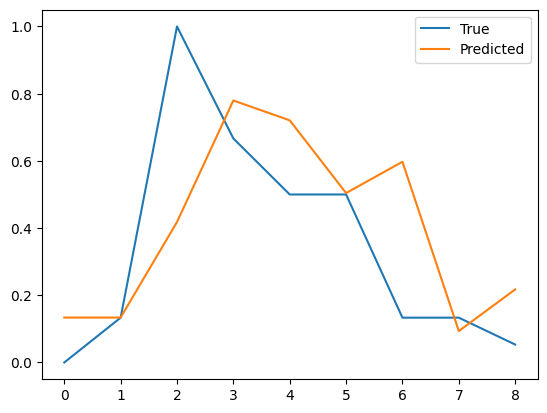

----------------xxxxx----------------
--------------------------------
Predicting for player ID: 8198
--------------------------------
[   8198    8198    8198 ... 1190411 1190411 1190411]
[ True  True  True ... False False False]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
True values: [0.   0.   0.   0.   0.6  1.   0.45 0.2  0.2 ]
Predicted values: [0.13374645 0.13374645 0.13374645 0.13374645 0.13374645 0.82938033
 0.80702776 0.46017748 0.10755749]
--------------------------------
--------------------------------
    transfermarkt_id transfer_date  market_value  player_id  total_injuries  \
3               8198    1995-07-01             0       8198              29   
4               8198    1996-07-01             0       8198              29   
5               8198    1997-07-01             0       8198              29   
6               8198    1998-07-01             0       8198              29   
7               8198    2000-07-01             0       8198              29   
8          

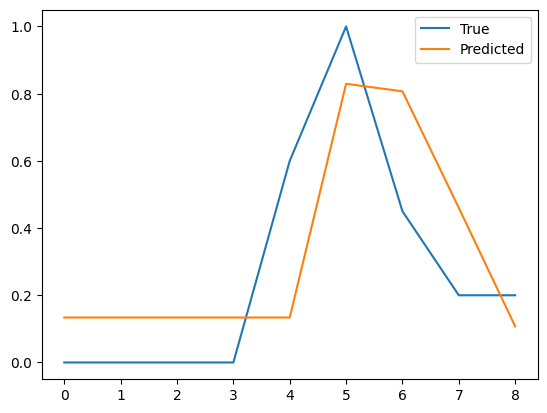

----------------xxxxx----------------
--------------------------------
Predicting for player ID: 1190411
--------------------------------
[   8198    8198    8198 ... 1190411 1190411 1190411]
[False False False ...  True  True  True]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
True values: [0.         0.03333333 1.        ]
Predicted values: [0.13374645 0.13374645 0.21264783]
--------------------------------
--------------------------------
      transfermarkt_id transfer_date  market_value  player_id  total_injuries  \
9552           1190411    2021-07-01             0    1190411               0   
9553           1190411    2022-07-01             0    1190411               0   
9554           1190411    2023-07-01             0    1190411               0   
9555           1190411    2023-10-01             0    1190411               0   
9556           1190411    2025-01-01       1000000    1190411               0   
9557           1190411    2025-07-02      30000000    1190411             

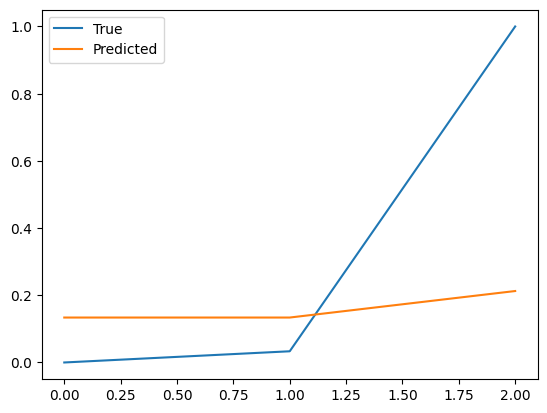

----------------xxxxx----------------
--------------------------------
Predicting for player ID: 51152
--------------------------------
[   8198    8198    8198 ... 1190411 1190411 1190411]
[False False False ... False False False]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
True values: [0.         0.10714286 0.39285714 0.28571429 0.28571429 0.53571429
 1.         0.64285714]
Predicted values: [0.13374645 0.13374645 0.36879873 0.6959972  0.5021418  0.46400803
 0.73684597 0.87456864]
--------------------------------
--------------------------------
    transfermarkt_id transfer_date  market_value  player_id  total_injuries  \
61             51152    2010-07-01             0      51152              15   
62             51152    2011-07-01             0      51152              15   
63             51152    2012-06-30             0      51152              15   
64             51152    2012-07-01             0      51152              15   
65             51152    2013-08-30       3000000      51

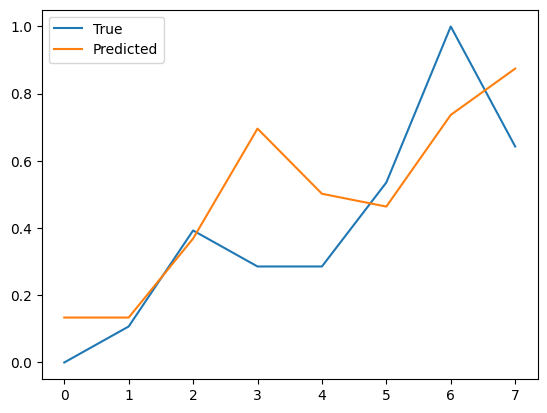

----------------xxxxx----------------
--------------------------------
Predicting for player ID: 33812
--------------------------------
[   8198    8198    8198 ... 1190411 1190411 1190411]
[False False False ... False False False]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
True values: [1.   0.72 0.72 0.6  0.18 0.18 0.12 0.07]
Predicted values: [0.80161613 0.8035191  0.7478405  0.7006354  0.64638543 0.08436754
 0.26001155 0.30712575]
--------------------------------
--------------------------------
    transfermarkt_id transfer_date  market_value  player_id  total_injuries  \
32             33812    2003-08-20             0      33812               2   
33             33812    2005-01-17             0      33812               2   
34             33812    2006-02-08       1250000      33812               2   
35             33812    2007-08-28       2500000      33812               2   
36             33812    2008-06-30       1800000      33812               2   
37             33812    20

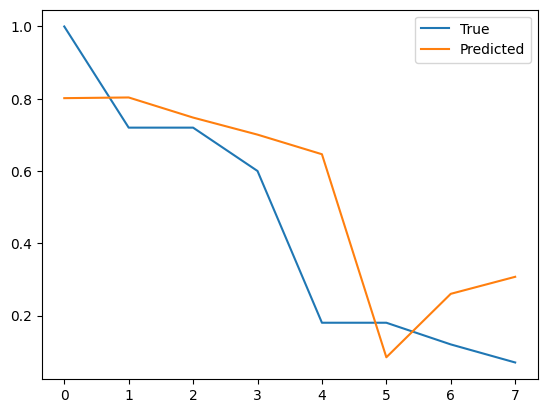

----------------xxxxx----------------
--------------------------------
Player ID not found in data. Please try another ID.
--------------------------------
--------------------------------
Predicting for player ID: 38253
--------------------------------
[   8198    8198    8198 ... 1190411 1190411 1190411]
[False False False ... False False False]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
True values: [0.01 0.09 1.   0.9 ]
Predicted values: [0.13374645 0.15795599 0.3350678  0.7800695 ]
--------------------------------
--------------------------------
    transfermarkt_id transfer_date  market_value  player_id  total_injuries  \
43             38253    2005-01-01             0      38253              24   
44             38253    2005-07-01             0      38253              24   
45             38253    2006-07-01             0      38253              24   
46             38253    2008-07-01        500000      38253              24   
47             38253    2010-07-01       4500000    

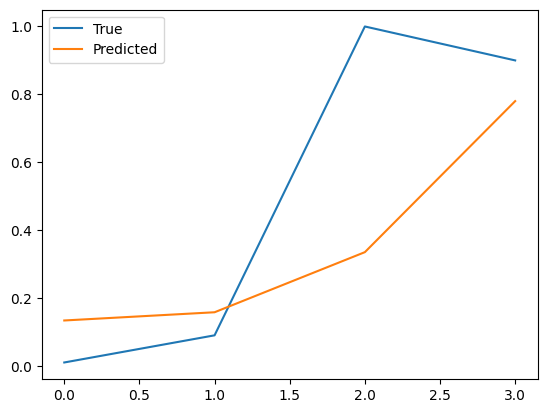

----------------xxxxx----------------
--------------------------------
Predicting for player ID: 129554
--------------------------------
[   8198    8198    8198 ... 1190411 1190411 1190411]
[False False False ... False False False]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
True values: [0.         0.0125     0.05       0.05       0.05       0.29166667
 0.33333333 0.45833333 0.45833333 1.        ]
Predicted values: [0.13374645 0.13374645 0.16393653 0.251738   0.2513904  0.2413449
 0.6261634  0.589303   0.6680028  0.6323447 ]
--------------------------------
--------------------------------
     transfermarkt_id transfer_date  market_value  player_id  total_injuries  \
380            129554    2007-07-01             0     129554              15   
381            129554    2008-07-01             0     129554              15   
382            129554    2009-07-01             0     129554              15   
383            129554    2010-07-01             0     129554              15   
384    

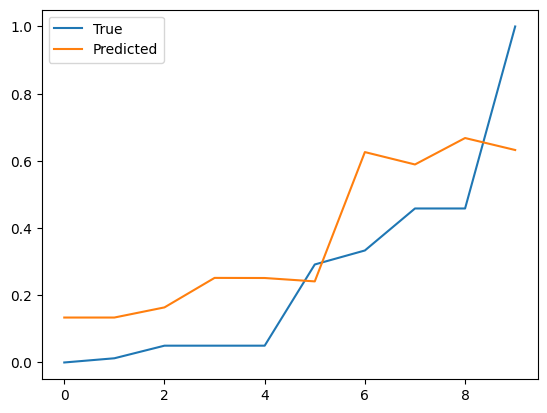

----------------xxxxx----------------
--------------------------------
Predicting for player ID: 129554
--------------------------------
[   8198    8198    8198 ... 1190411 1190411 1190411]
[False False False ... False False False]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
True values: [0.         0.0125     0.05       0.05       0.05       0.29166667
 0.33333333 0.45833333 0.45833333 1.        ]
Predicted values: [0.13374645 0.13374645 0.16393653 0.251738   0.2513904  0.2413449
 0.6261634  0.589303   0.6680028  0.6323447 ]
--------------------------------
--------------------------------
     transfermarkt_id transfer_date  market_value  player_id  total_injuries  \
380            129554    2007-07-01             0     129554              15   
381            129554    2008-07-01             0     129554              15   
382            129554    2009-07-01             0     129554              15   
383            129554    2010-07-01             0     129554              15   
384    

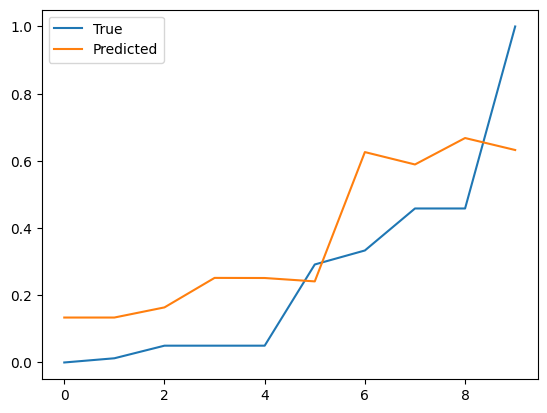

----------------xxxxx----------------


In [50]:
player_id = 28396
default_value = f"{player_id}"
user_input = default_value
while user_input.isdigit(): 
    user_input = input(f"Enter something (default: {default_value}).\n Enter any non-numeric value (eg:Stop) to stop predictions: ") or default_value
    if user_input.isdigit():
        pid = int(user_input)

    if pid not in df.transfermarkt_id.values:
        print("--------------------------------")
        print("Player ID not found in data. Please try another ID.")
        print("--------------------------------") 
        #exit()
    else:
        try:
            print("--------------------------------")
            print("Predicting for player ID:", pid)
            print("--------------------------------")
            print(np.array(player_index))
            mask = np.array(player_index)==pid
            print(mask)
            X_player = X[mask]
            y_true = y[mask]
            y_pred = model.predict(X_player)
            print("True values:", y_true)
            print("Predicted values:", y_pred.flatten())
            print("--------------------------------")
            selected_rows = df.loc[df['transfermarkt_id'] == pid]
            print("--------------------------------")
            print(selected_rows)
            print("--------------------------------")
            plt.plot(y_true, label='True')
            plt.plot(y_pred, label='Predicted')
            
            plt.legend()
            plt.show()
            print("----------------xxxxx----------------")
        except Exception as e:
            print("Error during prediction:", e)
            print("--------------------------------")
